<a href="https://colab.research.google.com/github/jakobzhao/geog428/blob/main/labs/lab02/Seattle_LST_Downscaling_with_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downscaling Land Surface Temperature in Seattle: Exploring Urban Heat and Modeling Strategies

**Author**: Bo Zhao, zhaobo@uw.edu  
**Affiliation**: Department of Geography, University of Washington

This lab investigates urban heat dynamics in the Seattle metropolitan area through a structured comparison of multiple downscaling models for Land Surface Temperature (LST). Our broader goal is twofold:

1. **Explore spatial patterns of urban heat** and how they relate to vegetation, land use, and built environment across distinct neighborhoods.
2. **Evaluate the performance of different modeling strategies**—from simple linear models to advanced random forest regressions—used to downscale coarse-resolution LST data (~ 1km) to finer spatial detail (~ 30m).

We begin by modeling LST using **NDVI as a lone predictor**, then incrementally incorporate **multi-band spectral features** and **geographic context** to build more complex predictive frameworks. All modeling and evaluation are conducted in **Google Earth Engine (GEE)** using remotely sensed data from **Landsat 8** and **Sentinel-2**.


## 🎯 Objectives

By completing this lab, you will:

- Use **Sentinel-2 imagery** to compute NDVI and other spectral indices.
- Understand how different predictors (NDVI, band combinations, geography) influence LST prediction.
- Apply and compare multiple models:  
  - **Linear regression with NDVI only**  
  - **Multivariate regression with selected spectral bands and indices**  
  - **Random Forest regression with expanded features**  
  - **Models incorporating spatial-geographic features**
- Evaluate models using **scatter plots, R², RMSE**, and residual diagnostics.
- Reflect on the **assumptions, performance trade-offs, and spatial implications** of each modeling approach.

---

## ⚙️ Lab Workflow Overview

### 1. Define Regions of Interest (ROIs)

Six Seattle-area neighborhoods are selected to reflect variation in urban structure and land cover.

### 2. Data Preparation

- Collect Landsat 8 LST and Sentinel-2 imagery for Summer 2024.
- Preprocess data with cloud filtering, masking, and index generation (e.g., NDVI).

### 3. Model Development and Evaluation

- Begin with **simple linear regression using NDVI**, visualized through scatter plots.
- Progress to models using **multiple spectral bands and indices** as inputs.
- Integrate **geographic features** to test spatially aware models.
- Train and test **Random Forest regressors** for downscaling LST.
- Evaluate using metrics like **R², RMSE**, and model interpretability tools.

### 4. Spatial Visualization and Interpretation

- Map and compare **original vs. downscaled LST** in each region.
- Analyze **temperature histograms** and **urban heat gradients**.
- Interpret relationships between built environment, vegetation, and thermal patterns.

### 5. Critical Reflection and Discussion

- Which model offers the best performance, and why?
- How do **different types of input features** affect results?
- What are the **epistemological and ethical implications** of statistical downscaling?
- Are there spatial biases or limitations that emerge in the modeling process?


## 🔧 Install and Import Dependent Libraries

To begin, we install the required Python packages and import all necessary libraries to work with Google Earth Engine and satellite-based spatial data.

We will use:
- `earthengine-api` for accessing GEE datasets,
- `geemap` for visualization and mapping,
- standard Python tools for data processing, plotting, and image handling.

This setup enables a fully cloud-based remote sensing workflow, especially suitable for working within Google Colab.


In [1]:
# Install core libraries for working with Google Earth Engine and visualizing geospatial data
%pip install -q earthengine-api  # GEE Python API
%pip install -q geemap           # Mapping and visualization support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.1 MB/s eta 0:00:00


In [2]:
# Earth Engine & Visualization Tools
import ee                   # Access Google Earth Engine Python API
import geemap               # Easy geospatial visualization and analysis in GEE

# Data Handling & Plotting
import numpy as np          # Numerical operations
import pandas as pd         # Tabular data manipulation
import matplotlib.pyplot as plt            # Basic plotting
import matplotlib.patheffects as PathEffects  # Add visual effects to plots (e.g., halo text)

# Image Downloading & Rendering
import urllib               # For downloading files (e.g., image thumbnails from GEE)
from PIL import Image       # For opening and displaying downloaded images

# Machine Learning (Scikit-learn)
from sklearn.model_selection import train_test_split, cross_val_score  # Train/test splitting & CV
from sklearn.ensemble import RandomForestRegressor                     # Random Forest model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error  # Evaluation metrics

# Google Drive Integration (for Google Colab)
from google.colab import drive        # Mount Google Drive to read/write files

### 🛠️ Before You Begin: Google Earth Engine Setup

To run this notebook, you will need access to **Google Earth Engine (GEE)**. Please follow the steps below before running the authentication code:

1. **Sign up for a GEE account** at [signup.earthengine.google.com](https://signup.earthengine.google.com/)  
   - Use your **personal Gmail** address rather than a university account, as many .edu domains are not supported.

2. During the signup process, choose the **"non-commercial" use** license.

3. You may be asked to provide a **credit card** for verification.  
   - **Don't worry**—this is for identity validation only. So far, no charges have been reported during normal use, and the API usage is minimal for educational labs.

4. Once registered, go to the [Google Cloud Console](https://console.cloud.google.com/):
   - **Create a new project**
   - Enable the **Earth Engine API**
   - Copy your **Project ID**

Then return to the notebook and run the following cell to authenticate:

```python
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='your-project-id-here')


In [ ]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-jakobzhao')

## 🗺️ Step 1: Define Regions of Interest (ROIs)

We begin our analysis by defining the spatial extent of our study: **Seattle, Washington**—a major urban center in the Pacific Northwest, known for its varied topography, mixed land use, and growing challenges related to climate resilience and urban heat.

To examine the spatial variability of land surface temperature (LST) at a finer resolution, we select **six representative regions** within the broader Seattle metropolitan area. These **Regions of Interest (ROIs)** were chosen based on their distinct land cover, urban form, and functional characteristics:

1. **University District**  
   A vibrant academic zone centered around the University of Washington, characterized by high vegetation cover, dense student housing, and institutional buildings.

2. **Capitol Hill**  
   A high-density, mixed-use neighborhood with limited green space, walkable streets, and diverse land use.

3. **West Seattle**  
   A residential region with heterogeneous land cover, including low-rise homes, forested patches, and significant elevation change.

4. **Bellevue Downtown**  
   A dense Eastside commercial and residential hub across Lake Washington, featuring high-rise buildings and urbanized land surfaces.

5. **Lynnwood Transit Center**  
   A suburban transportation node and future light rail anchor, dominated by impervious surfaces such as parking lots and highways.

6. **SeaTac Airport**  
   Seattle’s international airport area, defined by extensive paved runways and low vegetation, representing industrial urban heat profiles.

Each ROI is specified as a rectangular geometry using `ee.Geometry.Rectangle(...)` in Google Earth Engine. These regions serve as the units for comparing **original** and **downscaled LST**, and allow us to observe how microclimates vary across different urban landscapes.

In [4]:
# Define the bounding box for Seattle
roi = ee.Geometry.Rectangle([-123.2, 47.3, -121.5, 48.2])

regions = {
    'Univ. District': ee.Geometry.Rectangle([-122.323, 47.645, -122.295, 47.670]),
    'Capitol Hill': ee.Geometry.Rectangle([-122.330, 47.610, -122.310, 47.630]),
    'West Seattle': ee.Geometry.Rectangle([-122.400, 47.550, -122.360, 47.580]),
    'Bellevue Downtown': ee.Geometry.Rectangle([-122.210, 47.605, -122.180, 47.625]),
    'Lynnwood Transit Center': ee.Geometry.Rectangle([-122.290, 47.820, -122.260, 47.840]),
    'SeaTac Airport': ee.Geometry.Rectangle([-122.320, 47.430, -122.280, 47.460])
}

## 🗂️ Step 2: Data Preparation

In this step, we acquire and prepare the satellite datasets required for downscaling analysis.

We use two primary data sources available via **Google Earth Engine (GEE)**:

- **Landsat 8 Surface Temperature**  
  From the Collection 2 Level 2 archive, we extract Band 10 (thermal infrared) to derive **Land Surface Temperature (LST)**. This will serve as the dependent variable in our regression modeling.

- **Sentinel-2 Multispectral Imagery**  
  Sentinel-2 offers higher spatial resolution (10–20m), and is used here to calculate **Normalized Difference Vegetation Index (NDVI)**, which serves as a key predictor variable.

### Preprocessing Steps:

1. **Set Time Range**  
   We focus on **Summer 2024 (July–August)** to capture clear-sky and high-temperature conditions typical of urban heat buildup.

2. **Apply Cloud Filtering**  
   For **Landsat 8**, we use the `QA_PIXEL` band to mask clouds and ensure clean thermal signal. And for **Sentinel-2**, we filter scenes by `CLOUDY_PIXEL_PERCENTAGE < 10`.

3. **Median Composite**  
   A median reducer is applied to both collections to generate **cloud-free, temporally smoothed composite images** over the time range of interest.

4. **Compute NDVI**  
   NDVI is calculated from Sentinel-2’s red and near-infrared bands as (B8 − B4) / (B8 + B4).  
   
   It serves as a proxy for vegetation density and is commonly linked to surface temperature patterns.

5. **Convert LST to Fahrenheit**  
   Landsat thermal data is originally in scaled digital numbers. We convert it first to **Kelvin**, then to **Fahrenheit** for easier interpretation and visualization.

These clean, high-quality layers form the foundation for temperature prediction in the next step.

> ### What is NDVI?

> **NDVI** stands for **Normalized Difference Vegetation Index**. It is a widely used spectral index that measures the presence and health of vegetation using satellite imagery. NDVI is calculated from the **near-infrared (NIR)** and **red** bands of optical sensors. Usually,**Healthy vegetation** reflects more NIR and absorbs more red light, resulting in **higher NDVI values** (closer to 1), and **Bare soil, urban surfaces, or water** have lower NDVI values (closer to 0 or negative). Below shows the typical NDVI range:

> | NDVI Value | Interpretation                  |
> |------------|----------------------------------|
> | > 0.6      | Dense, healthy vegetation        |
> | 0.2 – 0.6  | Sparse or moderate vegetation    |
> | 0 – 0.2    | Barren ground or built-up areas  |
> | < 0        | Water, snow, or clouds           |

> In this lab, we use NDVI derived from **Sentinel-2 imagery** to represent vegetation coverage. It serves as a key predictor for downscaling land surface temperature, as vegetated areas tend to be cooler due to evapotranspiration.


In [24]:
# Load Landsat 8 Collection 2 Level 2 Surface Temperature data (ST_B10)
# Peak vegetation season in Seattle is typically from July to mid-August, so this date range is recommended.
landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                        .filterBounds(roi) \
                        .filterDate('2024-07-01', '2024-8-15')

# Function to apply cloud masking for Landsat 8
def mask_landsat_clouds(image):
    qa_pixel = image.select('QA_PIXEL')  # Select QA_PIXEL band for cloud masking
    cloud_mask = qa_pixel.bitwiseAnd(1 << 3).eq(0)  # Bit 3: cloud confidence is high (1 = no cloud)
    return image.updateMask(cloud_mask)

# Apply cloud masking to the Landsat collection
landsat_collection = landsat_collection.map(mask_landsat_clouds)

# Sort the collection by the most recent image
most_recent_image = landsat_collection.sort('system:time_start', False).first()

# Print metadata (e.g., acquisition date)
image_date = ee.Date(most_recent_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
print(f"Most recent Landsat image date: {image_date}")

# Select the thermal band (B10) and convert to temperature in Fahrenheit
# Landsat 8 Band 10 provides thermal infrared data in Kelvin
landsat_thermal = landsat_collection.select('ST_B10').median()

# Convert from Kelvin to Fahrenheit
lst_fahrenheit = landsat_thermal.multiply(0.00341802).add(149).subtract(273.15).multiply(9/5).add(32)

# Visualization parameters for LST in Fahrenheit
lst_vis_params = {
    'min': 0,     # Approx. -18°C
    'max': 120,   # Approx. 49°C
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}


# Load Sentinel-2 data
s2_collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
                    .filterBounds(roi) \
                    .filterDate('2024-07-01', '2024-08-10') \
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Select bands for NDVI calculation
s2_image = s2_collection.median()
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Update NDVI visualization parameters
ndvi_vis_params = {
    'min': -0.5,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']
}

# Create a map
Map = geemap.Map(center=[47.6062, -122.3321], zoom=11)

# Remove all default layers (basemaps or any others)
Map.clear_layers()
Map.add_basemap('SATELLITE')

# Visualize Sentinel-2 NDVI
Map.addLayer(ndvi, ndvi_vis_params, 'Sentinel-2 NDVI')

# Add NDVI legend
ndvi_legend = {
    'title': 'Land Cover Types (NDVI)',
    'categories': [
        {'color': 'brown', 'label': 'Low Vegetation/Non-Vegetated (-0.5 to 0)'},
        {'color': 'yellow', 'label': 'Sparse Vegetation (0 to 0.5)'},
        {'color': 'green', 'label': 'Moderate to Dense Vegetation (0.5 to 1)'}
    ]
}

# Add color bar to map for NDVI visualization
Map.add_colorbar(ndvi_vis_params, label="Sentinel-2 NDVI", position='bottomright')

# Visualize the LANSAT LST in Fahrenheit
Map.addLayer(lst_fahrenheit, lst_vis_params, 'LandSat LST (°F)')

# Add color bar for the LST
Map.add_colorbar(lst_vis_params, label='LST (°F)', position='bottomright')

# Display the map
Map

Most recent Landsat image date: 2024-08-11


Map(center=[47.6062, -122.3321], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

To understand the temperature distribution within a selected region, we extract all pixel values from the downscaled LST image using a `reduceRegion` operation. These values are converted into a list, then into a NumPy array for plotting. The histogram below visualizes the frequency of land surface temperatures (in °F) within the specified ROI.

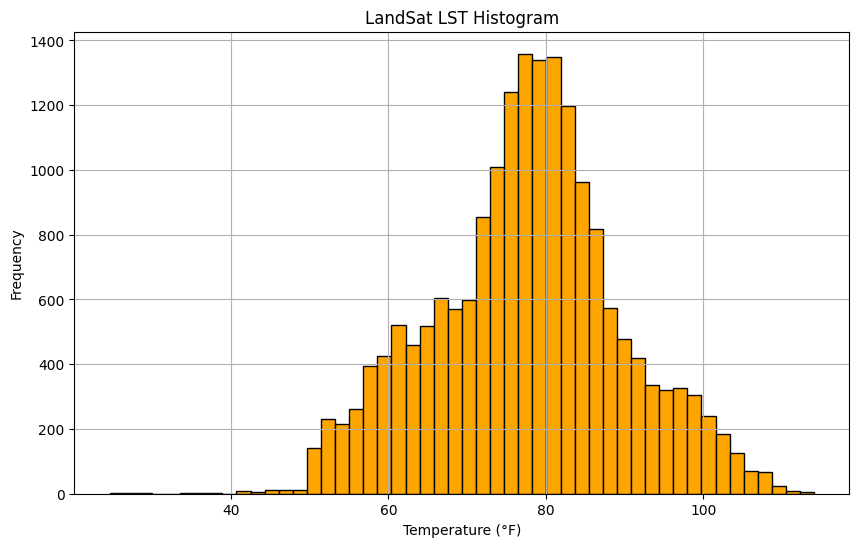

In [25]:
# Reduce the region to get the thermal radiance data as a list
thermal_radiance_data = lst_fahrenheit.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi,
    scale=1000,  # Adjust scale if necessary
    maxPixels=1e13
).get('ST_B10').getInfo()  # Get the values for the 'ST_B10' band and convert to a Python list

# Convert the data to a numpy array
thermal_radiance_array = np.array(thermal_radiance_data)

# Plot the histogram using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(thermal_radiance_array, bins=50, color='orange', edgecolor='black')
plt.title('LandSat LST Histogram')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This histogram, generated with the previous block of script, represents that most land surfaces in the region recorded temperatures between 75°F and 85°F, indicating this is the dominant thermal range across the city during late summer (August 11,2025). This peak likely corresponds to common urban environments such as residential areas, parks, and tree-lined streets.

On the cooler end of the spectrum, a small number of pixels fall between 40°F and 60°F, which may represent water bodies, heavily vegetated zones, or areas shaded by topography or tall structures. In contrast, the warmer tail, extending up to 110°F, suggests localized heat-retaining surfaces such as airport tarmacs, industrial areas, or large impervious zones like parking lots. The overall shape of the histogram resembles a slightly skewed bell curve, indicating a fairly continuous but asymmetric distribution of heat.

## 🤖 Step 3: Model Development and Evaluation

In this step, we explore different modeling strategies to predict land surface temperature (LST) from remote sensing data. Our goal is to understand which features—and which modeling approaches—are most effective in capturing spatial variation in urban heat.

We start with a simple linear regression using **NDVI** as the sole predictor to establish a baseline. Then, we progressively move to more complex models incorporating additional indices, spectral bands, and machine learning techniques.


### 📉 3.1 Linear Regression with NDVI

Before diving into machine learning, we begin with a straightforward exploratory analysis: examining the **linear relationship between NDVI and LST**.

Using data sampled from each Region of Interest (ROI), we plot NDVI values against LST (in °F) to uncover general trends and potential correlations. This helps us consider questions such as:

- Does increased vegetation correspond to lower temperatures?
- Are the relationships consistent across different neighborhoods?

We visualize these patterns using scatter plots and overlay a trend line to assess the **direction and strength** of the association.  
Though simple, this linear model provides valuable baseline insight and builds intuition for the more advanced models that follow.


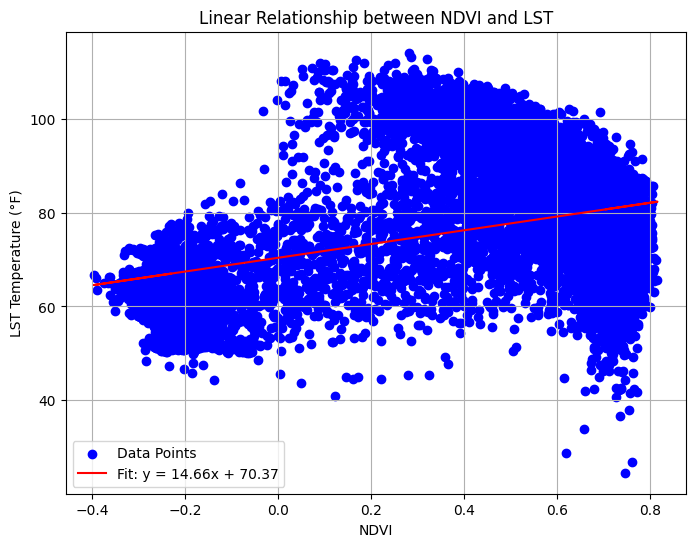

In [26]:
# Reproject NDVI to match the Sentinel-3 resolution (1000m)
ndvi_resampled = ndvi.reproject(crs=ee.Projection('EPSG:3857'), scale=1000).clip(roi)


# Aggregate NDVI to 1000m resolution
ndvi_aggregated = ndvi_resampled.reduceResolution(
    reducer=ee.Reducer.mean(),
    bestEffort=True,
    maxPixels=1024
).reproject(crs=lst_fahrenheit.projection(), scale=1000)

# Select only the thermal band from Sentinel-3 (in Celsius) and clip to the ROI
thermal_image = lst_fahrenheit.clip(roi)

# Mask out pixels where MODIS data is not available (MODIS LST data has no values)
valid_mask = thermal_image.mask().And(ndvi_aggregated.mask())

# Apply the mask to both images
ndvi_masked = ndvi_aggregated.updateMask(valid_mask)
thermal_masked = thermal_image.updateMask(valid_mask)

# Combine masked NDVI and thermal bands into a single image with only two bands
combined_image = ndvi_masked.addBands(thermal_masked)

# Sample the combined image (NDVI and Thermal) to extract pixel values
sampled_points = combined_image.sample(
    region=roi,  # Define the region of interest
    scale=1000,   # Use the same scale for both NDVI and thermal data
    numPixels=1e9, # Limit the number of pixels to 1,000,000,000 (one billion).
    geometries=False  # No need to include geometries (optional)
)

# Get NDVI and Thermal (LST) as separate lists
ndvi_list = sampled_points.aggregate_array('NDVI').getInfo()
thermal_list = sampled_points.aggregate_array('ST_B10').getInfo()


# Convert lists to numpy arrays
ndvi_values = np.array(ndvi_list)
thermal_values = np.array(thermal_list)

# Scatter plot of NDVI vs Thermal values
plt.figure(figsize=(8, 6))
plt.scatter(ndvi_values, thermal_values, color='blue', label='Data Points')

# Perform a linear fit
slope, intercept = np.polyfit(ndvi_values, thermal_values, 1)

# Plot the linear fit line
plt.plot(ndvi_values, slope * ndvi_values + intercept, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

# Add labels and title
plt.xlabel('NDVI')
plt.ylabel('LST Temperature (°F)')
plt.title('Linear Relationship between NDVI and LST')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The plot generated in the previous step reveals a weak yet positive linear relationship between NDVI and land surface temperature (LST) in Seattle on August 11, 2024. Therefore, we now introduce a more advanced technique—Random Forest regression—to evaluate whether a machine learning approach can capture the complex interactions among predictors and provide more accurate estimates of LST.

### 🌲 3.2 Random Forest Regression with NDVI

Building on the linear analysis, we now apply a **Random Forest regression model** using **NDVI as the sole input feature** to predict land surface temperature (LST).  
This represents our **first attempt at machine learning-based downscaling**, aiming to capture more complex, nonlinear relationships between vegetation cover and surface heat.

By training the model on sampled pixels across all ROIs, we generate high-resolution LST predictions at ~ 30m, downscaled from the original coarse-resolution LST (~ 1km).  
We then evaluate the model’s performance and inspect how well NDVI alone can drive prediction accuracy in a nonlinear framework.

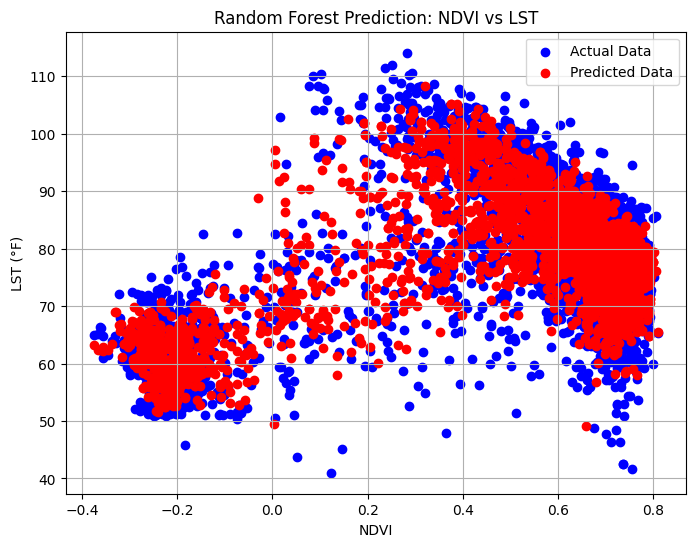

In [27]:
# Sample the combined NDVI and Thermal image to extract pixel values
sampled_points = combined_image.sample(
    region=roi,
    scale=1000,
    numPixels=1e9,  # Limit the number of pixels
    geometries=True
)


# Get NDVI and Thermal (LST) as separate lists
ndvi_list = sampled_points.aggregate_array('NDVI').getInfo()
thermal_list = sampled_points.aggregate_array('ST_B10').getInfo()

# Convert lists to numpy arrays
ndvi_values = np.array(ndvi_list).reshape(-1, 1)  # Reshape for scikit-learn
thermal_values = np.array(thermal_list)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ndvi_values, thermal_values, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


# Plot the predictions vs actual data
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred, color='red', label='Predicted Data')
plt.title('Random Forest Prediction: NDVI vs LST')
plt.xlabel('NDVI')
plt.ylabel('LST (°F)')
plt.legend()
plt.grid(True)
plt.show()

The scatter plot above compares the actual LST values (in blue) with the predicted values from the Random Forest model (in red), based on NDVI as the input feature. While the red and blue points do not perfectly overlap, the predicted values generally follow the same shape and range as the actual temperature distribution. This indicates that the model has learned a reasonable approximation of the relationship between NDVI and LST. The spread of red points across the entire NDVI range suggests that the Random Forest has captured some nonlinear patterns that were not visible in the previous linear regression.

However, discrepancies between actual and predicted values are still apparent—especially at low and high NDVI values—indicating that NDVI alone may not fully explain temperature variation across all land cover types.


📊 Model Evaluation (NDVI ➜ LST):
R²:   0.2578
RMSE: 10.3467
MAE:  7.6880


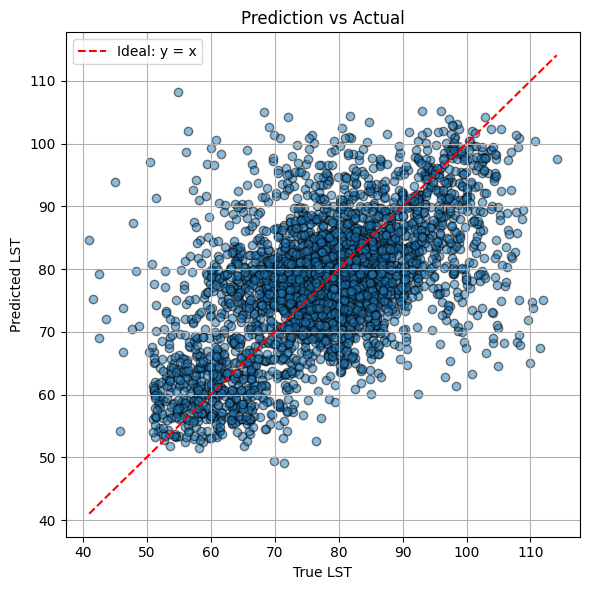

In [28]:
# 📊 Evaluate model performance metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 Model Evaluation (NDVI ➜ LST):")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# 1️⃣ Scatter plot: True vs Predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal: y = x')
plt.xlabel('True LST')
plt.ylabel('Predicted LST')
plt.title('Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot above shows a weak but positive relationship between NDVI and Land Surface Temperature (LST), modeled using a Random Forest regressor. The performance metrics indicate R² = ~ 0.25, RMSE = ~ 10.35°C, and MAE = ~ 7.69°C, suggesting that NDVI alone provides only limited predictive power. While the trend is generally upward, the wide spread of points around the ideal line (y = x) shows that the model struggles to capture the full variability in LST.

To further investigate, we now visualize the predicted results as a spatial map, allowing us to explore the geographic patterns and potential biases in the model’s output.

In [30]:
# Ensure both NDVI and LST have valid values
valid_mask = ndvi.mask().And(lst_fahrenheit.mask())

# Apply mask to both inputs
ndvi_masked = ndvi.updateMask(valid_mask)
lst_masked = lst_fahrenheit.updateMask(valid_mask).rename('ST_B10')  # Ensure correct label name

# Combine input and label
input_features_image = ndvi_masked.rename('NDVI')  # Rename to ensure consistent band name
training_image = input_features_image.addBands(lst_masked)

# Sample the image for training
sample_points = training_image.sample(
    region=roi,
    scale=100,
    numPixels=5000,
    seed=42,
    geometries=True
)

# Proceed only if we have training data
sample_points = sample_points.randomColumn('random')
training_set = sample_points.filter(ee.Filter.lt('random', 0.7))
validation_set = sample_points.filter(ee.Filter.gte('random', 0.7))

# Define features and label
input_features = ['NDVI']
label = 'ST_B10'

# Train Random Forest Regressor
regressor = ee.Classifier.smileRandomForest(numberOfTrees=200).setOutputMode('REGRESSION').train(
    features=training_set,
    classProperty=label,
    inputProperties=input_features
)

# Apply model
downscaled_temperature = input_features_image.classify(regressor).rename('Predicted_LST')

# Visualization parameters
lst_vis_params = {
    'min': 0,
    'max': 120,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}

# Create split map
left_layer = geemap.ee_tile_layer(lst_fahrenheit, lst_vis_params, 'Original LST (Fahrenheit)')
right_layer = geemap.ee_tile_layer(downscaled_temperature, lst_vis_params, 'Downscaled LST (RF)')

Map = geemap.Map(center=[47.6062, -122.3321], zoom=11)
Map.clear_layers()
Map.add_basemap('SATELLITE')
Map.split_map(left_layer, right_layer)
Map.add_colorbar(lst_vis_params, label='LST (°F)', position='bottomright')
Map

Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

The limitations of the Random Forest Model become much more evident when visualized in **geographic space**.

At lower zoom levels, the predicted LST map appears generally consistent with the original thermal distribution. However, when zooming into finer scales, the **spatial coherence breaks down**—the prediction begins to resemble **white noise**, lacking clear structural or environmental patterns.

#### Key Observations:

- **Water bodies** are poorly predicted, often displaying noisy temperature spikes where values should be uniformly low.
- **Built-up areas** show unrealistic thermal fluctuations that don’t follow expected urban heat gradients.
- The model fails to recognize key land surface features, likely because **NDVI alone lacks spatial context** and does not account for impervious surfaces, hydrology, or urban morphology.

These issues highlight that while NDVI captures vegetation, it is **not sufficient on its own** to support geospatially realistic temperature predictions.  


### 🌡️ 3.3 Expanding Features: Beyond NDVI

To improve model accuracy and better capture the complex spatial drivers of urban heat, we expanded the feature set beyond **NDVI**. While NDVI reflects vegetation density and greenness—factors linked to **evapotranspiration and localized cooling**—it alone does not fully explain variation in land surface temperature (LST).

We therefore included additional **spectral indices** and **reflectance bands** that represent a wider range of surface properties:

- **NDBI** (*Normalized Difference Built-up Index*): Highlights **impervious surfaces** such as roads and buildings, which typically **absorb and retain more heat**, raising LST.
- **NDWI** (*Normalized Difference Water Index*): Emphasizes **surface moisture and water bodies**, which are generally **cooler** due to evaporation and higher heat capacity.

We also added Sentinel-2 **reflectance bands** across key spectral ranges:
- **Visible**: B4 (red)
- **Near-infrared**: B8
- **Shortwave infrared**: B11 and B12

These bands respond to different land cover types—vegetation, bare soil, water, and urban surfaces—and indirectly reflect properties such as **surface albedo, emissivity, and thermal storage**. Incorporating them allows the model to learn from a broader set of surface energy characteristics and **improves prediction accuracy** in diverse urban environments.


In [31]:
# Calculate NDVI
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Calculate NDBI
ndbi = s2_image.normalizedDifference(['B11', 'B8']).rename('NDBI')

# Calculate NDWI
ndwi = s2_image.normalizedDifference(['B3', 'B8']).rename('NDWI')

# Select original spectral bands (surface reflectance)
bands = ['B4', 'B8', 'B11', 'B12']  # Blue, Green, Red, NIR, SWIR1, SWIR2

# Combine all features into one image
input_features_image = s2_image.select(bands).addBands([ndvi, ndbi, ndwi])

# Combine input features and LST for training
training_image = input_features_image.addBands(lst_fahrenheit)

# Extract sample points from the training image
sample_points = training_image.sample(
    region=roi,
    scale=100,  # larger than the smallest resolution, which is the Sentinel-2 resolution
    numPixels=5000,  # Increase number of samples for better training
    seed=42,
    geometries=True
)

# Add a random column for splitting into training and validation sets
sample_points = sample_points.randomColumn('random')

# Split into training and validation sets
training_set = sample_points.filter(ee.Filter.lt('random', 0.7))
validation_set = sample_points.filter(ee.Filter.gte('random', 0.7))

# Specify input features and label
input_features = bands + ['NDVI', 'NDBI', 'NDWI']
# input_features = ['NDVI', 'NDBI', 'NDWI']
label = 'ST_B10'

# Train the Random Forest regression model in GEE
regressor = ee.Classifier.smileRandomForest(
    numberOfTrees=200,   # Increase number of trees
    # Only valid parameters are used here
).setOutputMode('REGRESSION').train(
    features=training_set,
    classProperty=label,
    inputProperties=input_features
)


# Apply the model to the entire input features image
downscaled_temperature = input_features_image.classify(regressor).rename('Predicted_LST')

lst_vis_params = {
    'min': 0,     # Approx. -18°C
    'max': 120,   # Approx. 49°C
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}


# Add the first LST layer to map1 (for 2023-2024)
left_layer = geemap.ee_tile_layer(lst_fahrenheit, lst_vis_params,'Local Temperature (Fahrenheit)')


# Add the second LST layer to map2 (for 2013-2014)
right_layer = geemap.ee_tile_layer(downscaled_temperature, lst_vis_params, 'Downscaled LST (Random Forest)')

# Create a map
Map = geemap.Map(center=[47.6062, -122.3321], zoom=10)
# Remove all default layers (basemaps or any others)
Map.clear_layers()
Map.add_basemap('SATELLITE')
Map.split_map(left_layer, right_layer)
Map.add_colorbar(lst_vis_params, label='LST (°F)', position='bottomright')
Map

Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

The left panel shows the original coarse-resolution LST, while the right panel displays the predicted, downscaled LST using the enhanced model. Visually, the predicted map captures finer spatial details—such as neighborhood structure, vegetation corridors, and land cover variation—with much higher clarity.

Compared to the NDVI-only result, this output shows stronger spatial consistency and geographic coherence, more faithfully reflecting the urban landscape. This highlights the importance of incorporating multiple spectral features and spatial indices to generate LST predictions that are not only numerically accurate but also geographically meaningful.


📊 Model Evaluation (multi-bands + indices ➜ LST):
Cross-Validation R² (mean ± std): 0.6560 ± 0.0558
R²:  0.6897
RMSE: 6.81 °F
MAE:  5.22 °F


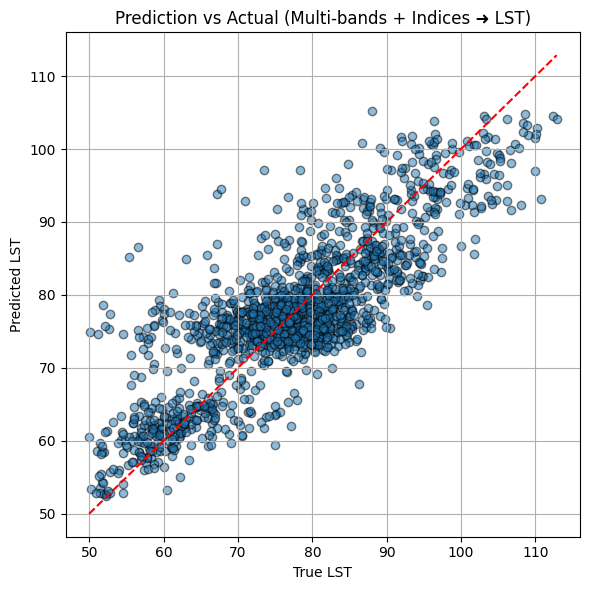

In [33]:
# Classify the validation set using the trained regressor and attach predicted values as a new property
validated = validation_set.classify(regressor).map(
    lambda f: f.set('Predicted_LST', f.get('classification'))
)

# Retrieve features from Earth Engine as a list of dictionaries
features = validated.getInfo()['features']

# Extract attribute dictionaries and convert to a DataFrame
props = [f['properties'] for f in features]
df = pd.DataFrame(props)

# Clean the DataFrame and convert LST-related fields to numeric types
df = df.dropna(subset=['ST_B10', 'Predicted_LST']).copy()
df['ST_B10'] = df['ST_B10'].astype(float)
df['Predicted_LST'] = df['Predicted_LST'].astype(float)

# Define input features and output labels for evaluation (excluding spatial coordinates)
input_features = ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NDBI', 'NDWI']
X = df[input_features].values
y_test = df['ST_B10'].values
y_pred = df['Predicted_LST'].values

# Perform 5-fold cross-validation using Random Forest on the true input features and observed LST
model = RandomForestRegressor(n_estimators=200, random_state=42)
cv_scores = cross_val_score(model, X, y_test, cv=5, scoring='r2')

# Compute regression evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print summary statistics
print(f"\n📊 Model Evaluation (multi-bands + indices ➜ LST):")
print(f"Cross-Validation R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"R²:  {r2:.4f}")
print(f"RMSE: {rmse:.2f} °F")
print(f"MAE:  {mae:.2f} °F")

# Plot scatter of true vs predicted LST
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('True LST')
plt.ylabel('Predicted LST')
plt.title('Prediction vs Actual (Multi-bands + Indices ➜ LST)')
plt.grid(True)
plt.tight_layout()
plt.show()

Compared to the NDVI-only model, the inclusion of additional spectral bands and indices (such as NDWI and NDBI) led to a significant improvement in model performance. The R² is approximately 0.69—much higher than the previous ~0.26—indicating that nearly 69% of the variation in surface temperature is explained. RMSE hovers around 6.8°F, and MAE is close to 5.2°F, both reflecting a clear accuracy gain.

While these values may slightly vary across different runs, the overall pattern remains consistent: a richer feature set substantially improves both model accuracy and spatial coherence.

### 🌐 3.4 Adding Geographic Features

Building on the improved performance achieved with spectral bands and indices, we now ask: **can incorporating geographic features further enhance the model?**

Urban surface temperature is influenced not only by surface materials, but also by broader spatial factors such as neighborhood structure, zoning patterns, and infrastructure networks.

To explore this possibility, we introduce simple **geographic context variables**—such as locational attributes and latitude-longitude coordinates—to evaluate whether they help the model better capture the underlying spatial logic of urban heat distribution.

In [34]:
# Calculate NDVI
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Calculate NDBI
ndbi = s2_image.normalizedDifference(['B11', 'B8']).rename('NDBI')

# Calculate NDWI
ndwi = s2_image.normalizedDifference(['B3', 'B8']).rename('NDWI')

# Get pixel longitude and latitude and rename the bands
lon = s2_image.pixelLonLat().select('longitude').rename('lon')
lat = s2_image.pixelLonLat().select('latitude').rename('lat')

# Select original spectral bands (surface reflectance)
bands = ['B4', 'B8', 'B11', 'B12']  # Blue, Green, Red, NIR, SWIR1, SWIR2

# Combine all features into one image, INCLUDING lon and lat
input_features_image = s2_image.select(bands).addBands([ndvi, ndbi, ndwi, lon, lat]) # Add lon and lat here

# Combine input features and LST for training
training_image = input_features_image.addBands(lst_fahrenheit)

# Extract sample points from the training image
sample_points = training_image.sample(
    region=roi,
    scale=100,  # larger than the smallest resolution, which is the Sentinel-2 resolution
    numPixels=5000,  # Increase number of samples for better training
    seed=42,
    geometries=True
)

# Add a random column for splitting into training and validation sets
sample_points = sample_points.randomColumn('random')

# Split into training and validation sets
training_set = sample_points.filter(ee.Filter.lt('random', 0.7))
validation_set = sample_points.filter(ee.Filter.gte('random', 0.7))

# Specify input features and label
# This list should match the bands included in input_features_image for classification
input_features = bands + ['NDVI', 'NDBI', 'NDWI', 'lon','lat']
label = 'ST_B10'

# Train the Random Forest regression model in GEE
regressor = ee.Classifier.smileRandomForest(
    numberOfTrees=200,   # Increase number of trees
    # Only valid parameters are used here
).setOutputMode('REGRESSION').train(
    features=training_set,
    classProperty=label,
    inputProperties=input_features
)


# Apply the model to the entire input features image
# Now input_features_image contains 'lon' and 'lat' bands, matching the classifier's expectations
downscaled_temperature = input_features_image.classify(regressor).rename('Predicted_LST')

lst_vis_params = {
    'min': 0,     # Approx. -18°C
    'max': 120,   # Approx. 49°C
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}


# Add the first LST layer to map1 (for 2023-2024)
left_layer = geemap.ee_tile_layer(lst_fahrenheit, lst_vis_params,'Local Temperature (Fahrenheit)')


# Add the second LST layer to map2 (for 2013-2014)
right_layer = geemap.ee_tile_layer(downscaled_temperature, lst_vis_params, 'Downscaled LST (Random Forest)')

# Create a map
Map = geemap.Map(center=[47.6062, -122.3321], zoom=10)
# Remove all default layers (basemaps or any others)
Map.clear_layers()
Map.add_basemap('SATELLITE')
Map.split_map(left_layer, right_layer)
Map.add_colorbar(lst_vis_params, label='LST (°F)', position='bottomright')
Map

Map(center=[47.6062, -122.3321], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…


📊 Model Evaluation with Geographic Features:
Cross-Validation R² (mean ± std): 0.7827 ± 0.0405
R²:  0.8027
RMSE: 5.49 °F
MAE:  4.11 °F


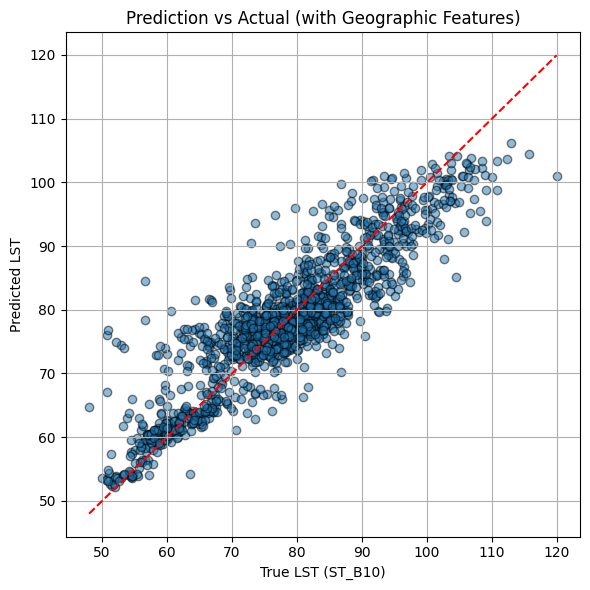

In [35]:
# Classify the validation set using the trained regressor and attach predicted values as a new property
validated = validation_set.classify(regressor).map(
    lambda f: f.set('Predicted_LST', f.get('classification'))
)


# Download validation data from GEE (assuming 'validated' is already defined)
features = validated.getInfo()['features']
props = [f['properties'] for f in features]
coords = [f['geometry']['coordinates'] for f in features]

# Build a DataFrame and append longitude and latitude
df = pd.DataFrame(props)
df['lon'] = [c[0] for c in coords]
df['lat'] = [c[1] for c in coords]

# Remove missing values and ensure numeric format
df_clean = df.dropna(subset=['ST_B10', 'Predicted_LST']).copy()
df_clean['ST_B10'] = df_clean['ST_B10'].astype(float)
df_clean['Predicted_LST'] = df_clean['Predicted_LST'].astype(float)

# Prepare features and labels
input_features = ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NDBI', 'NDWI', 'lon', 'lat']
X = df_clean[input_features].values
y_test = df_clean['ST_B10'].values
y_pred = df_clean['Predicted_LST'].values

# Train a local Random Forest model for cross-validation (evaluation only)
model = RandomForestRegressor(n_estimators=200, random_state=42)
cv_scores = cross_val_score(model, X, y_test, cv=5, scoring='r2')

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"\n📊 Model Evaluation with Geographic Features:")
print(f"Cross-Validation R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"R²:  {r2:.4f}")
print(f"RMSE: {rmse:.2f} °F")
print(f"MAE:  {mae:.2f} °F")

# Visualization: Predicted vs. Actual Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('True LST (ST_B10)')
plt.ylabel('Predicted LST')
plt.title('Prediction vs Actual (with Geographic Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

After incorporating geographic features—such as latitude, longitude, and other spatial context—the model shows a noticeable improvement in performance compared to the previous version.

The **R² score is approximately 0.80**, suggesting that the model can now explain about 80% of the variation in land surface temperature (LST). Both **RMSE and MAE have also decreased**, with RMSE around 5.5°F and MAE near 4.1°F. Cross-validation results are similarly strong and consistent across folds.

While the spatial output remains visually similar to the earlier map, the improved statistics indicate that **including geographic information helps the model better capture spatial structure**, especially in areas where spectral signals alone may be ambiguous.


## 🔹 Step 5: Spatial Visualization and Interpretation

In this step, we compare the **original Land Surface Temperature (LST)** data with the **downscaled LST predictions** generated by our Random Forest model, across six selected regions in the Seattle metropolitan area.

For each region:
- We extract static temperature maps using `getThumbURL()` for both the **original Landsat LST** and the **predicted high-resolution LST**.
- We also compute and plot a **histogram** showing the distribution of LST values (in °F) within the region, based on the original thermal image.

This visualization allows us to assess the **spatial detail enhancement** and **distributional differences** introduced by the downscaling process.

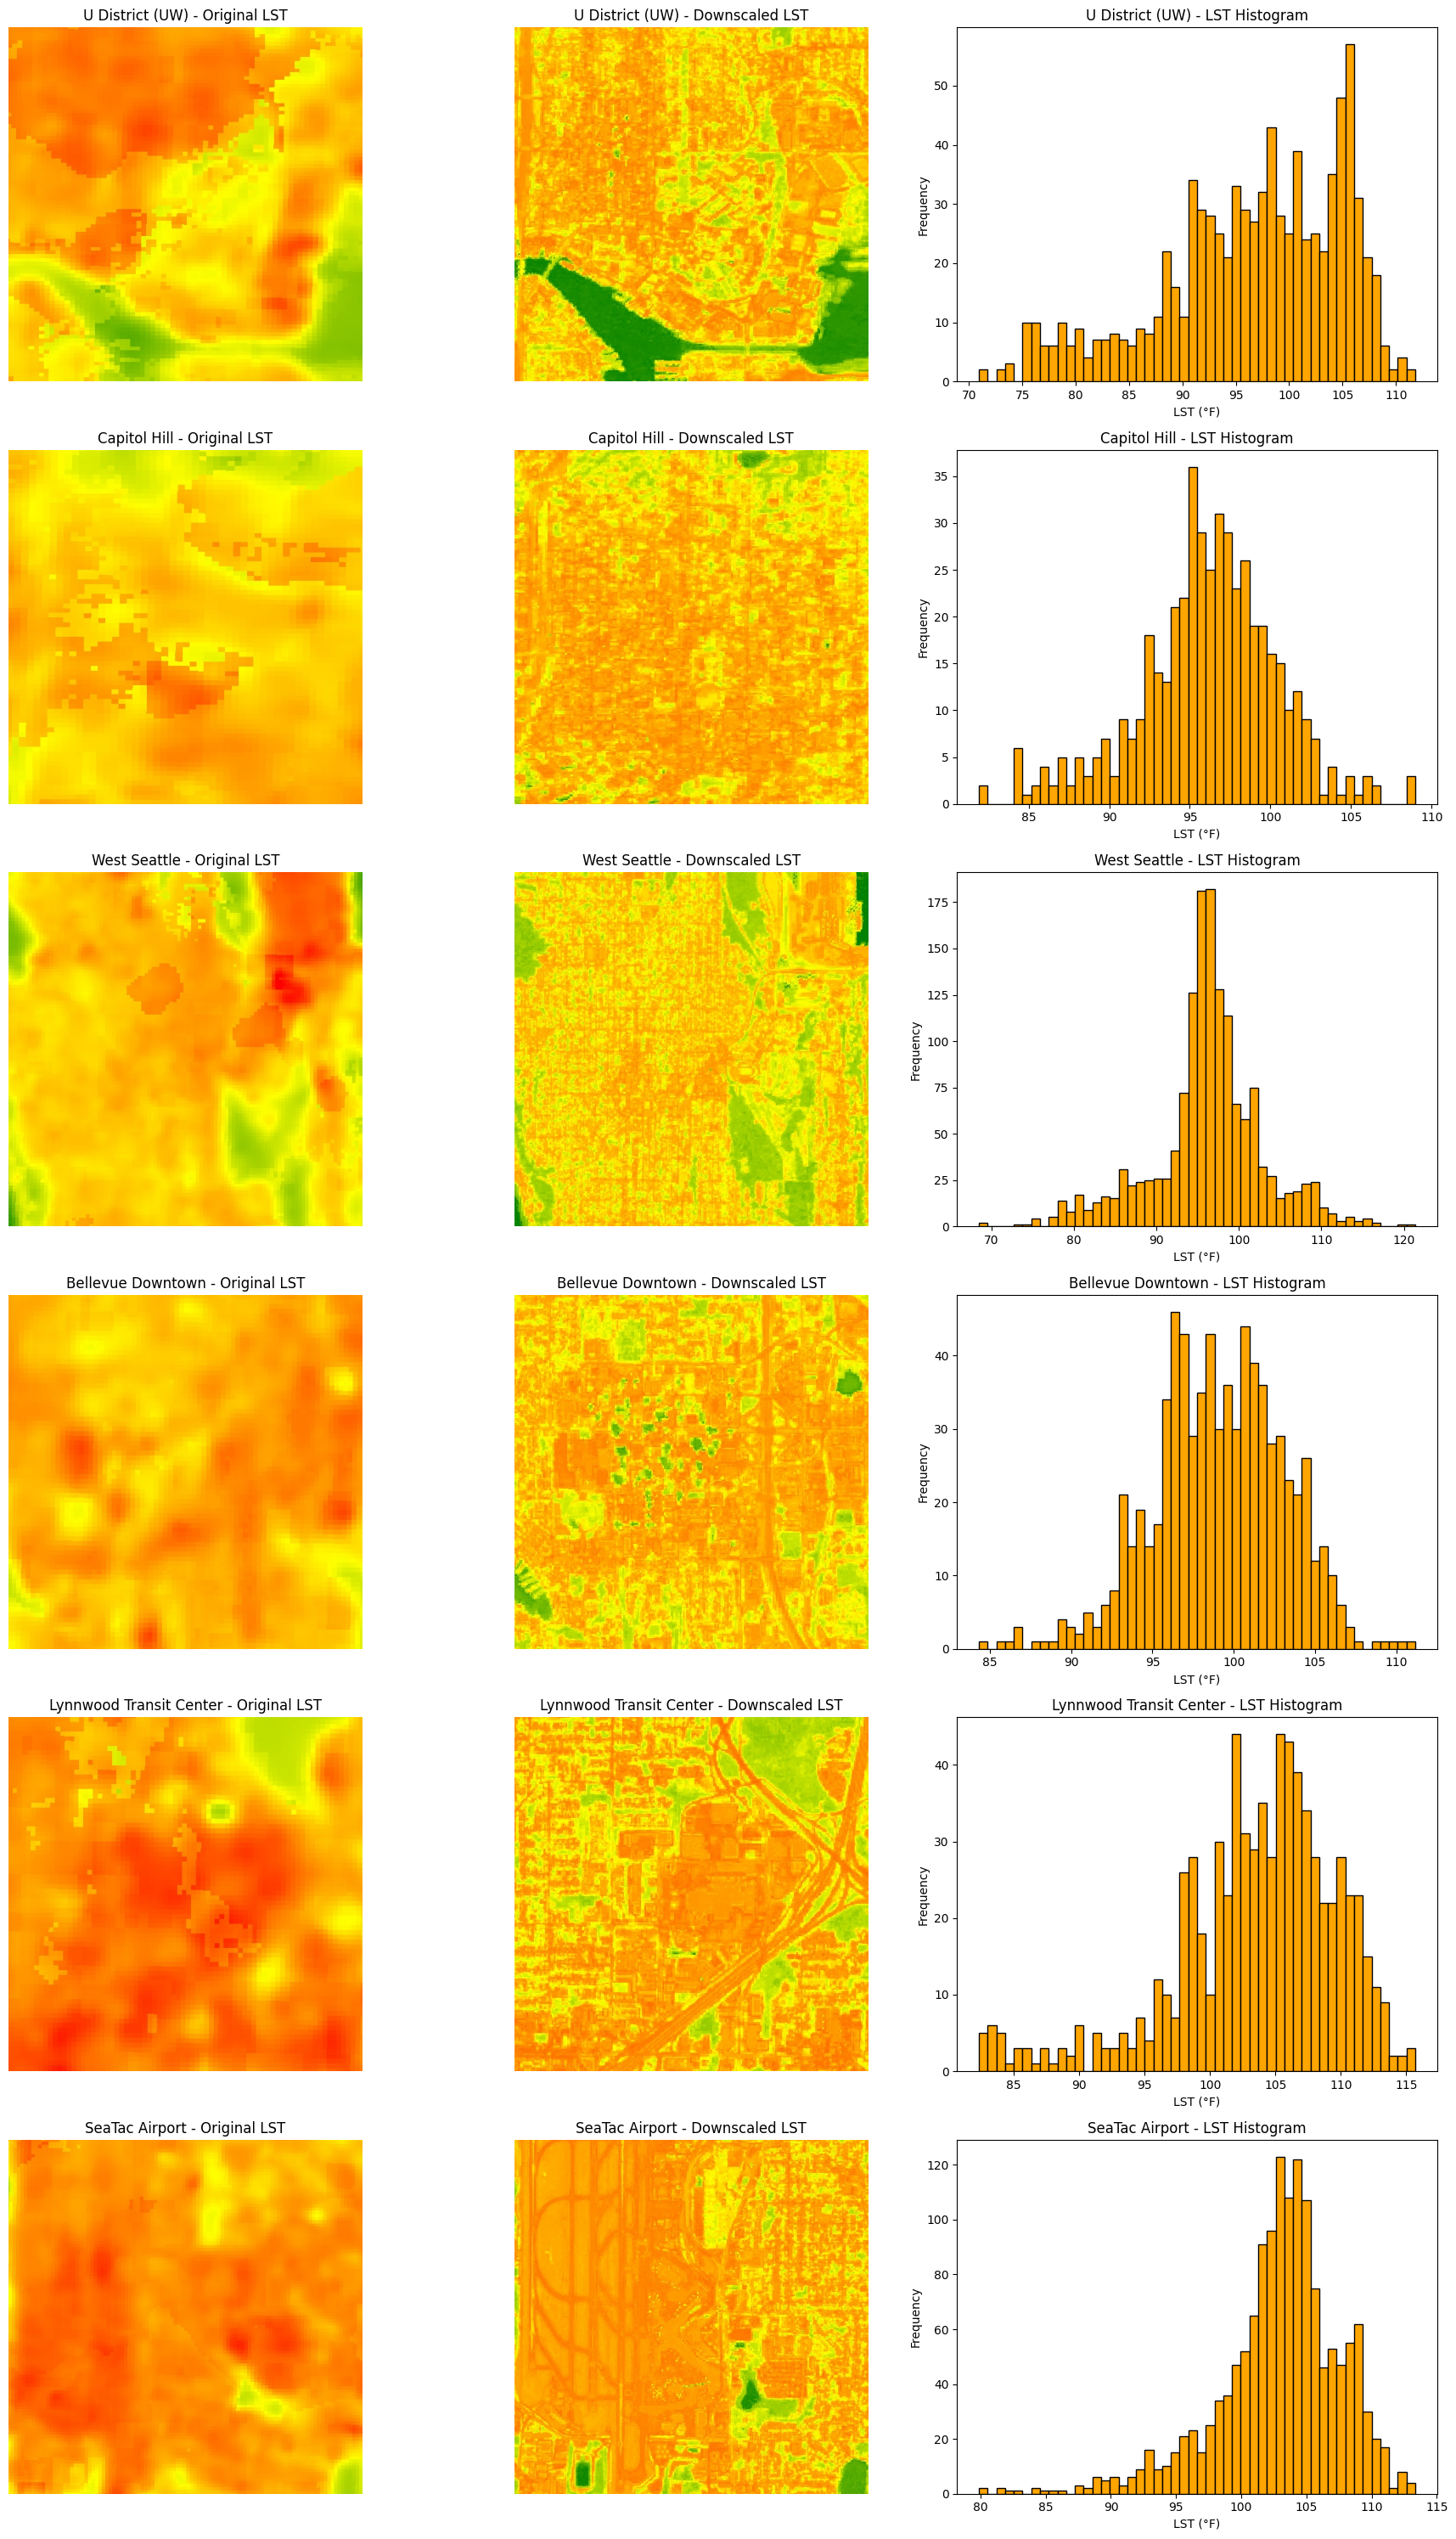

In [36]:
# Function to calculate the histogram data for a region
def get_lst_histogram(region_geom):
    """
    Get the Land Surface Temperature (LST) histogram data for the given region.
    """
    thermal_radiance_data = lst_fahrenheit.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=region_geom,
        scale=100,
        maxPixels=1e13
    ).get('ST_B10').getInfo()  # Get the values for the 'ST_B10' band

    return np.array(thermal_radiance_data)
# Function to download the images as arrays from Google Earth Engine (static output)
def download_image(image, region, dimensions=(512, 512)):
    """
    Downloads the image as a numpy array from Earth Engine without specifying scale.
    """
    url = image.getThumbURL({
        'region': region,
        'min': lst_vis_params['min'],
        'max': lst_vis_params['max'],
        'palette': lst_vis_params['palette'],
        'dimensions': dimensions  # Using dimensions for the image size
    })
    with urllib.request.urlopen(url) as file:
        img = Image.open(file)
        return np.array(img)

regions = {
    'U District (UW)': ee.Geometry.Rectangle([-122.323, 47.645, -122.295, 47.670]),
    'Capitol Hill': ee.Geometry.Rectangle([-122.330, 47.610, -122.310, 47.630]),
    'West Seattle': ee.Geometry.Rectangle([-122.400, 47.550, -122.360, 47.580]),
    'Bellevue Downtown': ee.Geometry.Rectangle([-122.210, 47.605, -122.180, 47.625]),
    'Lynnwood Transit Center': ee.Geometry.Rectangle([-122.290, 47.820, -122.260, 47.840]),
    'SeaTac Airport': ee.Geometry.Rectangle([-122.320, 47.430, -122.280, 47.460])
}

original_images = {}
downscaled_images = {}

for region_name, region_geom in regions.items():
    original_images[region_name] = download_image(lst_fahrenheit, region_geom)
    downscaled_images[region_name] = download_image(downscaled_temperature, region_geom)

# Plot both original and downscaled LST for each region
fig, axes = plt.subplots(len(regions), 3, figsize=(18, 5 * len(regions)))

for idx, (region_name, region_geom) in enumerate(regions.items()):
    w, h = original_images[region_name].shape[1], original_images[region_name].shape[0]

    # Original LST
    axes[idx, 0].imshow(original_images[region_name])
    axes[idx, 0].set_title(f'{region_name} - Original LST')
    axes[idx, 0].axis('off')

    # Downscaled LST
    axes[idx, 1].imshow(downscaled_images[region_name])
    axes[idx, 1].set_title(f'{region_name} - Downscaled LST')
    axes[idx, 1].axis('off')

    # Histogram (based on original)
    lst_array = get_lst_histogram(region_geom)
    axes[idx, 2].hist(lst_array, bins=50, color='orange', edgecolor='black')
    axes[idx, 2].set_title(f'{region_name} - LST Histogram')
    axes[idx, 2].set_xlabel('LST (°F)')
    axes[idx, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Interpretation of the Output Figure

The figure presents results for six regions in the Seattle metropolitan area:  
**U District (UW), Capitol Hill, West Seattle, Bellevue Downtown, Lynnwood Transit Center, and SeaTac Airport**.  
Each row corresponds to one specific region and includes:

1. **Original LST Image** – A coarse-resolution thermal image (~1 km) that appears smooth but lacks detail and sharp boundaries. Urban features are largely indistinguishable.  
2. **Downscaled LST Image** – A fine-resolution output (100 m) produced by a Random Forest regression model. This version reveals much more spatial texture and structural detail, including roads, green patches, and urban morphology.  
3. **LST Histogram** – The frequency distribution of surface temperatures (°F) within each region, reflecting thermal variance and microclimate conditions.


###  Key Observations:

- The **downscaled LST maps** display clearer spatial structures—such as street grids, parks, and industrial zones—which are **completely absent** in the original coarse-resolution maps.
- In **U District (UW)** and **West Seattle**, we observe a strong thermal contrast between vegetated and built-up areas, illustrating the capability of the downscaling method to reveal **localized heat heterogeneity**.
- The **histograms** show varied thermal distributions:
  - **SeaTac Airport** and **Lynnwood Transit Center** exhibit **right-skewed histograms**, indicating that a large portion of the area is covered by **high-temperature surfaces**—consistent with asphalt runways and transit hubs.
  - In contrast, **Capitol Hill** and **Bellevue Downtown** display **more symmetric, bell-shaped distributions**, likely reflecting mixed land uses, including shaded residential zones and vegetation buffers.
- The **downscaled predictions** better capture **hotspots** and **cool corridors**, which are essential for applications in **urban planning, heat-risk mitigation, and environmental equity**.


This visualization demonstrates the value of machine learning–based downscaling in enhancing the spatial resolution of satellite-derived temperature data. By recovering fine-scale urban thermal patterns, these results offer richer insights into how heat is distributed across neighborhoods—insights that are not only useful for environmental monitoring but also critical for **climate adaptation, public health**, and **infrastructure planning** in urban settings.


### 💾 Exporting Downscaled LST for External Use

The following code exports the downscaled land surface temperature (LST) image as a GeoTIFF file to your Google Drive. This allows the predicted high-resolution temperature data to be accessed and used in other platforms such as QGIS, ArcGIS, or Python-based workflows.

> Note: The export process typically takes several minutes (often 10–20 minutes), depending on image size and server load. Please be patient. The file will appear in the folder `EarthEngineExports` of your mounted Google Drive once the task is complete.

In [ ]:
# Export the downscaled temperature image as GeoTIFF
# Mount Google Drive to access data files
drive.mount('/content/drive', force_remount=True)

downscaled_temp_export = ee.batch.Export.image.toDrive(
    image=downscaled_temperature,
    description='Downscaled_Temperature',
    folder='EarthEngineExports',
    fileNamePrefix='Downscaled_Temperature',
    region=roi,
    scale=10, # You might want to adjust the scale depending on your needs
    crs='EPSG:4326',
    maxPixels=1e13
)
downscaled_temp_export.start()

## 🔎 Step 6: Reflection and Discussion

After experimenting with multiple models and feature sets, we've seen how different inputs shape the prediction of urban land surface temperature (LST). Starting with NDVI-only models, we gradually incorporated additional spectral bands, derived indices (such as NDBI and NDWI), and eventually geographic features like latitude and longitude.

Each of these additions improved the model in different ways:
- **Spectral richness** helped capture more detailed surface composition.
- **Indices** brought thematic meaning tied to vegetation, built-up areas, and water presence.
- **Geographic features** reinforced spatial structure and improved predictive consistency across regions.

These variations illustrate an important point: **model performance is deeply influenced by the kinds of features we include**—and each layer of complexity brings both new insights and new challenges.


### ❓ Questions to Consider

- Which features had the most impact on model performance—and why?
- How do different indices (e.g., NDVI vs. NDBI) reflect thermal dynamics on the ground?
- In what ways does adding geographic information change how a model "sees" space?
- Can latitude and longitude be meaningful predictors, or are they just proxies?
- When do more features help, and when do they risk overfitting the model?
- Would this model generalize well to other cities? Why or why not?
- What are the ethical or ecological implications of using machine learning to represent environmental phenomena like urban heat?

Take time to think critically about the **trade-offs between model complexity, interpretability, and reliability**, especially in a geographic context. In the end, geospatial AI is not just about improving accuracy—it's about making meaningful, place-based sense of the patterns we model.
